In [1]:
import pandas as pd
import numpy as np
import shap
import pickle
import matplotlib.pyplot as plt
import os
FIGURES_DIR = "../reports/figures"

C:\Users\jevsez\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/processed/train_final.csv')
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
X_sample = X.sample(2000, random_state=42)

model_path = "../model/model.pkl"
with open(model_path, 'rb') as f:
    model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/train_final.csv'

In [10]:
# Initialisation de l'explainer
explainer = shap.TreeExplainer(model)

# Calcul des valeurs SHAP (Contribution de chaque feature pour chaque client)
shap_values = explainer.shap_values(X_sample)

# LightGBM binaire renvoie parfois une liste [Class0, Class1].
# Nous, on veut expliquer la Classe 1 (Le risque de défaut).
if isinstance(shap_values, list):
    shap_values = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    expected_value = explainer.expected_value

print(f"Dimensions des SHAP values : {shap_values.shape}")

Dimensions des SHAP values : (2000, 362)


C:\Users\jevsez\AppData\Roaming\Python\Python313\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Ce graphique classe les variables par importance dans l'ordre décroissant. L'axe X indique l'impact sur le risque

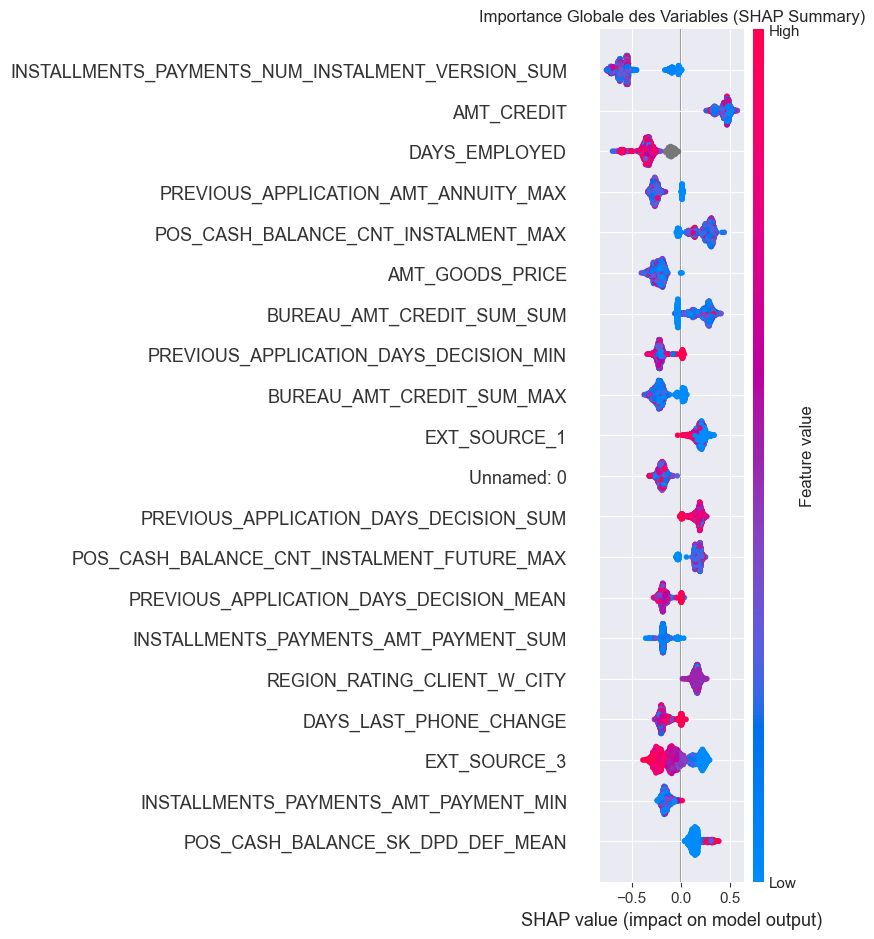

In [18]:
plt.figure(figsize=(10, 12))
plt.title("Importance Globale des Variables (SHAP Summary)")

# Affiche les features les plus impactantes
# Les points rouges = valeurs élevées de la variable
# Vers la droite = augmente le risque / Vers la gauche = baisse le risque
shap.summary_plot(shap_values, X_sample, show=False)

# Sauvegarde
plt.savefig(os.path.join(FIGURES_DIR, 'shap_global.png'), bbox_inches='tight')
plt.show()


On choisit le client le plus risqué de l'échantillon et le graphique ci-dessous permet de justifier ces point forts/faibles qui influent sur le risque

Analyse du client index 1065 (Risque calculé : 68.39%)


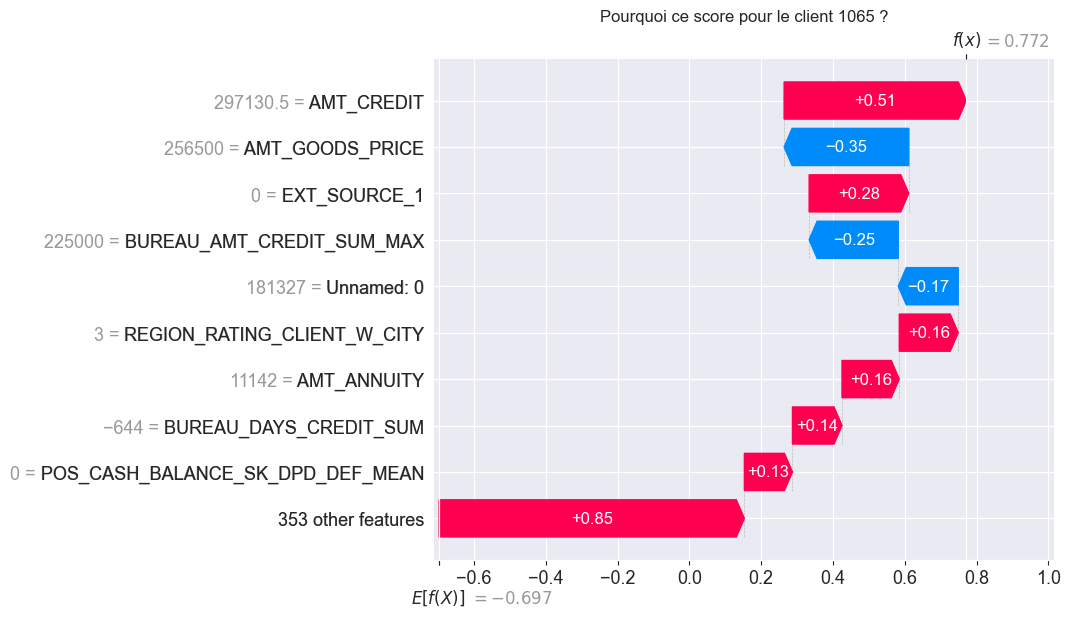

In [12]:
probas = model.predict_proba(X_sample)[:, 1]
client_idx = np.argmax(probas) # Le client le plus risqué de l'échantillon

print(f"Analyse du client index {client_idx} (Risque calculé : {probas[client_idx]:.2%})")

# Construction de l'objet Explanation pour le graphique Waterfall
# (SHAP moderne a besoin de cet objet structuré)
exp = shap.Explanation(
    values=shap_values[client_idx],
    base_values=expected_value,
    data=X_sample.iloc[client_idx],
    feature_names=X_sample.columns
)

plt.figure(figsize=(8, 8))
plt.title(f"Pourquoi ce score pour le client {client_idx} ?")
# Le graphique en cascade
shap.plots.waterfall(exp, show=False)

# Sauvegarde
plt.savefig(os.path.join(FIGURES_DIR, 'shap_local.png'), bbox_inches='tight')
plt.show()